In [1]:
%load_ext autoreload
%autoreload 2

# Test smina (and AmberTools)

Some code is deactivated.<br/>
Now smina is run through by a function

### Needs rdkit>=2020.03.3

In [2]:
import rdkit
assert '2020.03.3' <= rdkit.__version__

In [3]:
from cbiprep.ligand_expo import LigandExpo
from cbiprep.smina import RunSmina, CheckRMSD
from cbiprep.jupyter_utils import draw_mol, check_dir
import pandas as pd
import os, time, sys, random

In [4]:
lig_expo = LigandExpo()

In [5]:
df = pd.read_pickle('index_2019.pkl.gz')

### SMINA docking as a function

Inputs:
- pdb_code
- ligand_name
- workdir = 'work'
- ncpu = os.cpu_count()
- num_modes = 4
- seed = 0

### SMINA for all PDBs

In [6]:
DF = df[(df['type'] == 'Kd') & (df['lig_ok'] == True) & (df['refined'] == True)]

----------------------------------------------------------------------------------------------------
3r6u CHT C[N+](C)(C)CCO


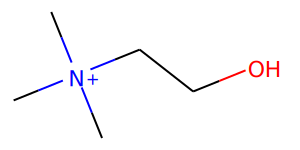

tleap -s -f work/3r6u/3r6u_tleaprc > /dev/null 2>&1
obabel work/3r6u/3r6u_relevant.mol2 -O work/3r6u/3r6u_charged.mol2 > /dev/null 2>&1
smina -r work/3r6u/3r6u_charged.mol2 -l work/3r6u/3r6u_ligand_CHT_mmff.sdf --center_x 0.0 --center_y -0.0 --center_z -0.0 --size_x 15.354 --size_y 14.346 --size_z 13.359 --cpu 12 --num_modes 4 --seed 0 -o work/3r6u/3r6u_ligand_CHT_docked.sdf --log work/3r6u/3r6u_CHT_smina.log
1 0.455
2 0.448
3 0.639
4 0.388
Lapse = 1.6s
----------------------------------------------------------------------------------------------------
4leq 1WK CNc1nc2c(CC[C@H]3O[C@@H](OC)[C@H](O)[C@@H]3O)c3nc(N)[nH]c(=O)c3cc2[nH]1


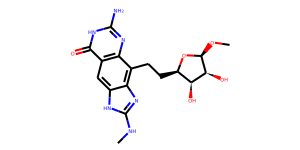

tleap -s -f work/4leq/4leq_tleaprc > /dev/null 2>&1
obabel work/4leq/4leq_relevant.mol2 -O work/4leq/4leq_charged.mol2 > /dev/null 2>&1
smina -r work/4leq/4leq_charged.mol2 -l work/4leq/4leq_ligand_1WK_mmff.sdf --center_x 0.0 --center_y -0.0 --center_z 0.0 --size_x 21.089 --size_y 22.01 --size_z 14.132 --cpu 12 --num_modes 4 --seed 0 -o work/4leq/4leq_ligand_1WK_docked.sdf --log work/4leq/4leq_1WK_smina.log
1 1.784
2 1.787
3 1.781
4 1.788
Lapse = 9.1s
----------------------------------------------------------------------------------------------------
5f2p 5TY CN(C)c1ncc2c(=O)n(C)ccc2n1


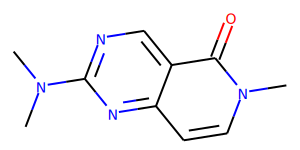

tleap -s -f work/5f2p/5f2p_tleaprc > /dev/null 2>&1
obabel work/5f2p/5f2p_relevant.mol2 -O work/5f2p/5f2p_charged.mol2 > /dev/null 2>&1
smina -r work/5f2p/5f2p_charged.mol2 -l work/5f2p/5f2p_ligand_5TY_mmff.sdf --center_x 0.0 --center_y 0.0 --center_z -0.022 --size_x 20.106 --size_y 15.433 --size_z 12.094 --cpu 12 --num_modes 4 --seed 0 -o work/5f2p/5f2p_ligand_5TY_docked.sdf --log work/5f2p/5f2p_5TY_smina.log
1 0.175
2 0.119
3 0.147
4 0.148
Lapse = 2.0s
----------------------------------------------------------------------------------------------------
5f60 5VZ Cc1cnc(Nc2ccc(N3CCN(C)CC3)cc2)nc1Nc1ccc(Cl)c(NS(=O)(=O)C(C)(C)C)c1


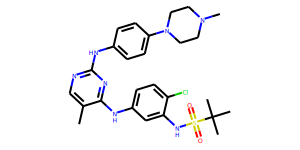

tleap -s -f work/5f60/5f60_tleaprc > /dev/null 2>&1
obabel work/5f60/5f60_relevant.mol2 -O work/5f60/5f60_charged.mol2 > /dev/null 2>&1
smina -r work/5f60/5f60_charged.mol2 -l work/5f60/5f60_ligand_5VZ_mmff.sdf --center_x 0.0 --center_y -0.0 --center_z 0.109 --size_x 32.575 --size_y 14.875 --size_z 19.048 --cpu 12 --num_modes 4 --seed 0 -o work/5f60/5f60_ligand_5VZ_docked.sdf --log work/5f60/5f60_5VZ_smina.log


In [ ]:
indices = list(DF.index)
random.shuffle(indices)
for idx in indices:
    r = DF.loc[idx]
    pdb_code = r['pdb']
    ligand_name = r['lig']
    rmsd_oname = f'work/{pdb_code}/rmsd'
    if os.path.exists(rmsd_oname):
        continue
    print('-'*100)
    start = time.time()
    try:
        docked_sdf = RunSmina(pdb_code, ligand_name, ncpu=12)
    except:
        print(f'Error: {pdb_code} {ligand_name}', file=sys.stderr)
        continue
    with open(rmsd_oname, 'wt') as out:
        for i, rmsd in enumerate(CheckRMSD(pdb_code, ligand_name, docked_sdf), start=1):
            print(i, rmsd)
            print(i, rmsd, file=out)
    lapse = time.time() - start
    print(f'Lapse = {lapse:.1f}s')